# Punto 1
## Automatic identification of “trending/viral” topics around COVID in time in the World using deep learning architectures. Type: Different approaches.

In [2]:
import pickle as pk
import pandas as pd
import numpy as np
import json
from sklearn.feature_extraction.text import CountVectorizer
from stop_words import get_stop_words
import umap.umap_ as umap


## Files used
The datasets and the embedings generated with a pretrained Sentence Bert model

In [3]:
#prefix = './drive/MyDrive/'
prefix = ''
english_path = prefix + 'datasets/english/english_out_hash_bien.json'

#prefix = './drive/MyDrive/'
prefix = ''
english_embeddings_path = prefix + 'models_hpc/embeddings_en_hash.pickle'

#prefix = './drive/MyDrive/'
prefix = ''
umap_english_embeddings_path = prefix + 'models_hpc/umap_en_hash.pickle'


In [3]:
'''
------------------------ENGLISH---------------------------

------------------------ENGLISH---------------------------

------------------------ENGLISH---------------------------
'''

'\n------------------------ENGLISH---------------------------\n\n------------------------ENGLISH---------------------------\n\n------------------------ENGLISH---------------------------\n'

## English

In [4]:
file = open(english_path, 'r')
data = []
for line in file:
    data.append(json.loads(line))

text_raw_df = pd.json_normalize(data)

print(text_raw_df.shape)
text_raw_df.head(10)

(784932, 4)


,id,publication_date,source,text
0,1295929115770593287,1.597809e+09,twitter,Info Source:
1,1296738518216011777,1.598002e+09,twitter,#PostponeJEE_NEETSept #ProtestAgainstExamsInCO...
2,1252450676015198210,1.587442e+09,twitter,Coronavirus-spreader Chris Cuomo got a lecture...
3,1380684968880406528,1.618016e+09,twitter,Any military member that refuses to get vaccin...
4,1368958702150156290,1.615220e+09,twitter,#Covid19 is staying around for a while. your ...
5,1317169175203401735,1.602873e+09,twitter,LIES!!! LIES!!!
6,1288154256449708032,1.595955e+09,twitter,"@GregMannarino Deborah BirxWhite House ""Expert"""
7,1283867253222502400,1.594933e+09,twitter,Kayleigh McEnany: ‘Science Should Not Stand in...
8,1286909343909240832,1.595658e+09,twitter,Amazing effort from the guys! Please donate if...
9,1235895985009811461,1.583496e+09,twitter,@SulaiOdus They said it was suspended due to c...


In [5]:
'''
Turn text to Numpy Array
'''
texts_column = text_raw_df.loc[:,'text']
raw_texts = texts_column.values
raw_texts[0]

'Info Source: '

In [6]:
with open(english_embeddings_path, "rb") as output_file:
    embeddings = pk.load(output_file)

with open(umap_english_embeddings_path, "rb") as output_file:
    umap_embeddings = pk.load(output_file)

### HDBSCAN para el clustering

In [7]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=70,
                          metric='euclidean',
                          cluster_selection_method='eom').fit(umap_embeddings)


### c-TF-IDF

In [8]:
docs_df = pd.DataFrame(raw_texts, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [11]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(raw_texts))

In [12]:

def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
10,9,769824
8,7,12326
0,-1,1487
6,5,375
3,2,205
2,1,164
4,3,147
1,0,110
5,4,105
9,8,95


In [13]:
for topic in topic_sizes['Topic']:
  if topic == -1:
    continue
  print('Topic #' + str(topic) +":"+ '\n')
  print(str([t[0] for t in top_n_words[topic][:20]]) + '\n')

Topic #9:

['covid', '19', 'coronavirus', 'covid19', 'new', 'cases', 'people', 'trump', 'pandemic', 'amp', 'vaccine', 'just', 'news', 'health', 'deaths', 'like', 'don', 'positive', 'realdonaldtrump', 'time']

Topic #7:

['china', 'chinese', 'coronavirus', 'wuhan', 'virus', 'covid', 'outbreak', '19', 'world', 'beijing', 'taiwan', 'covid19', 'lab', 'communist', 'trump', 'news', 'new', 'pandemic', 'people', 'vaccine']

Topic #5:

['empower', '090', 'entertain', '0208', '2121', 'educate', 'hello', 'air', 'talk', 'fantasticradio', 'african', 'uk', 'nonstop', 'affairs', 'tune', 'radio', 'playing', 'music', 'live', 'fantasticradi']

Topic #2:

['appointments', '00', 'cvs', 'near', 'pa', '04', 'sign', 'available', 'vaccination', '2021', '03', '19', 'covid', 'rite', 'aid', '23', '21', '09', '08', '54']

Topic #1:

['spain', 'strict', 'worn', 'outdoors', 'masks', 'lockdown', 'inside', 'spanish', 'extremely', 'indoors', 'mandatory', 'particularly', 'despite', 'coverings', 'outdo', 'des', 'look', 

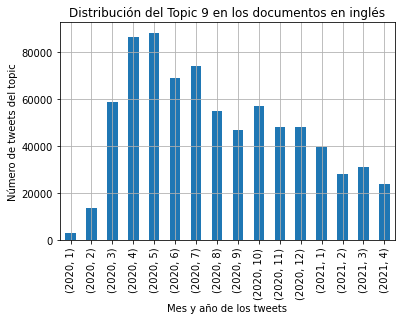

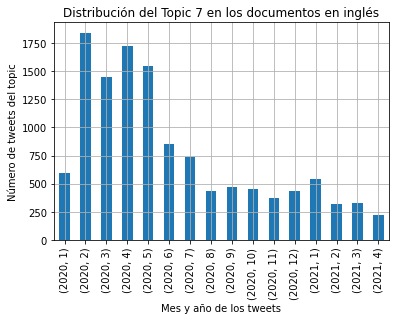

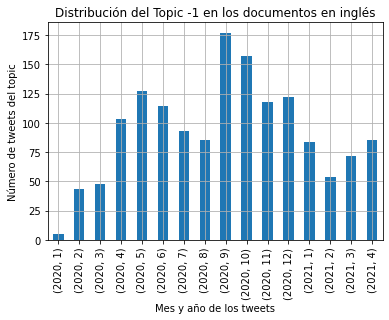

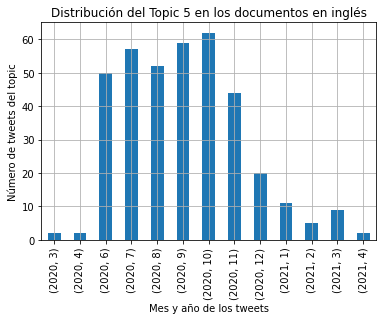

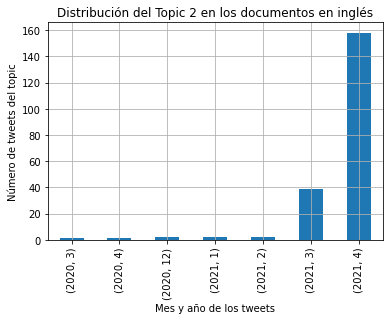

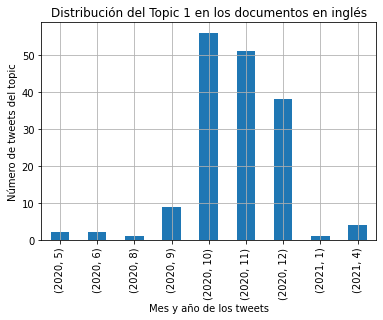

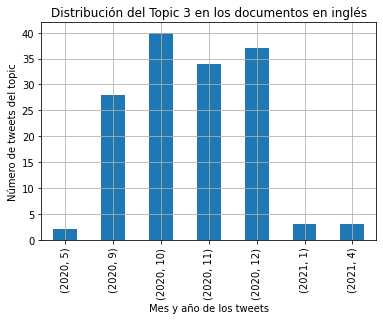

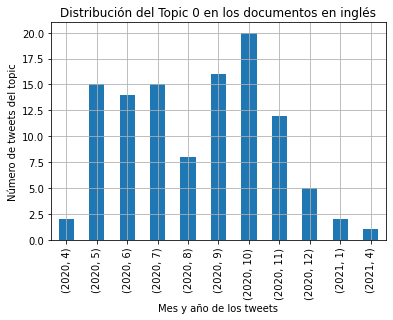

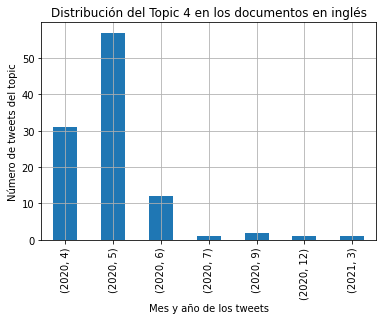

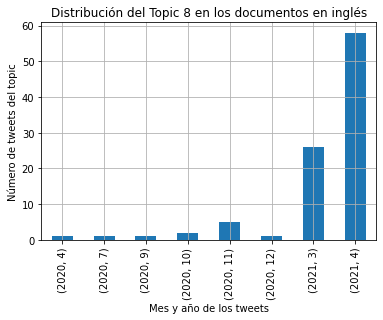

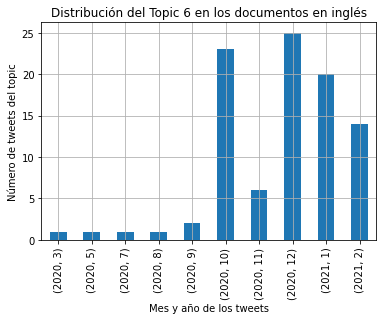

In [14]:
import matplotlib.pyplot as plt
from datetime import datetime


text_raw_df['dates'] =  text_raw_df['publication_date'].apply(lambda x:  datetime.fromtimestamp(x))
text_raw_df['Topic'] = cluster.labels_
text_raw_df


for num_topic in topic_sizes['Topic']:
    ax = text_raw_df.groupby([text_raw_df['Topic'], text_raw_df['dates'].dt.year, text_raw_df['dates'].dt.month]).count()['id'][num_topic].plot(kind="bar") #Imprime el topic cero
    ax.grid(b=True, axis='both')
    #print(type(ax))
    ax.set_title('Distribución del Topic ' + str(num_topic) + ' en los documentos en inglés')
    ax.set_xlabel('Mes y año de los tweets')
    ax.set_ylabel('Número de tweets del topic')
    plt.show()

### Visualisación de los clusters

In [15]:
with open("models_hpc/umap_en_graph.pickle", "rb") as output_file:
    umap_embeddings_graph = pk.load(output_file)

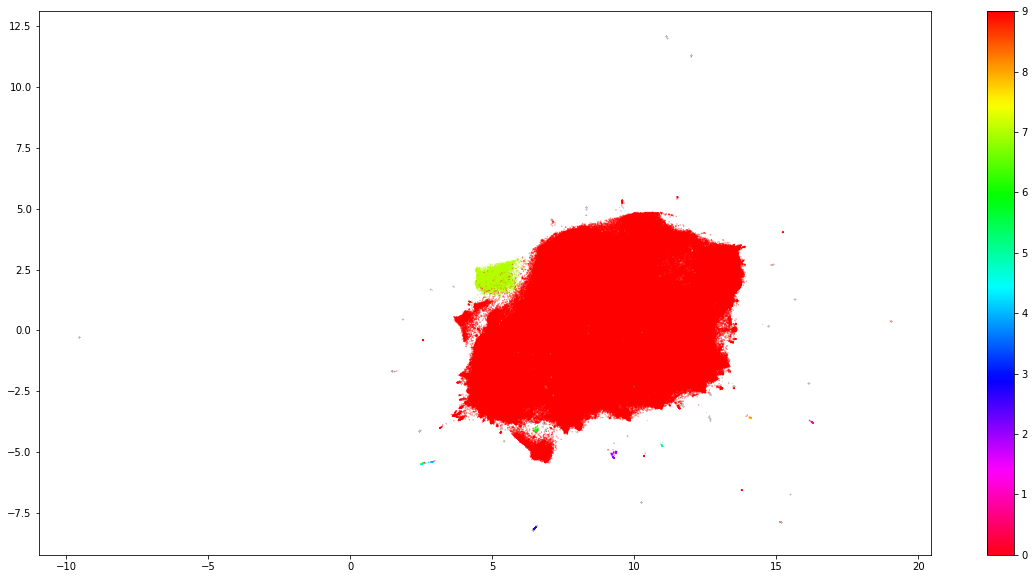

In [16]:
import matplotlib.pyplot as plt

# Prepare data
umap_data = umap_embeddings_graph
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()



### HDBSCAN para el clustering

In [22]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=30,
                          metric='euclidean',
                          cluster_selection_method='eom').fit(umap_embeddings)


### c-TF-IDF

In [23]:
docs_df = pd.DataFrame(raw_texts, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [24]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(raw_texts))

In [25]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)


,Topic,Size
0,-1,646461
29,28,12189
19,18,8640
372,371,4860
396,395,4570
250,249,4287
392,391,3989
215,214,3765
284,283,3748
120,119,3100


In [26]:
len(topic_sizes)

418

In [27]:
for topic in topic_sizes['Topic']:
  if topic == -1:
    continue
  print('Topic #' + str(topic) +":"+ '\n')
  print(str([t[0] for t in top_n_words[topic][:20]]) + '\n')


Topic #28:

['china', 'chinese', 'coronavirus', 'wuhan', 'virus', 'covid', '19', 'outbreak', 'world', 'beijing', 'taiwan', 'covid19', 'lab', 'communist', 'trump', 'news', 'new', 'pandemic', 'people', 'vaccine']

Topic #18:

['canada', 'ontario', 'canadian', '19', 'covid', 'cases', 'toronto', 'canadians', 'alberta', 'cbc', 'new', 'covid19', 'news', 'trudeau', 'health', 'quebec', 'ottawa', 'vaccine', 'coronavirus', 'government']

Topic #371:

['trump', 'president', 'donald', 'coronavirus', 'biden', 'administration', 'covid', '19', 'response', 'realdonaldtrump', 'obama', 'white', 'house', 'says', 'campaign', 'news', 'amp', 'gop', 'covid19', 'just']

Topic #395:

['fuck', 'fucking', 'stupid', 'sad', 'shit', 'bad', 'idiot', 'hell', 'disgusting', 'oh', 'damn', 'scary', 'dumb', 'really', 'shame', 'man', 'fucked', 'bitch', 'just', 'evil']

Topic #249:

['covid', 'cases', '19', 'lowest', '000', 'coronavirus', 'rate', 'million', 'deaths', 'new', 'percent', 'people', 'jobs', 'drop', 'half', '50',

### Visualisación de los clusters

In [ ]:
with open("models_hpc/umap_en_graph.pickle", "rb") as output_file:
    umap_embeddings_graph = pk.load(output_file)

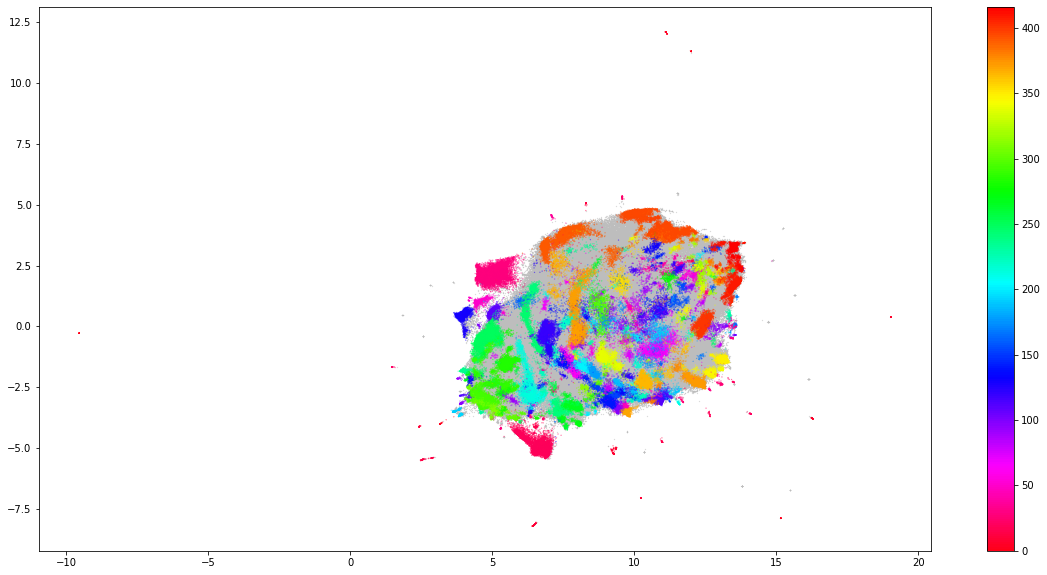

In [28]:
import matplotlib.pyplot as plt

# Prepare data
umap_data = umap_embeddings_graph
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()